In [1]:
#! pip install  keras
#! pip install  sklearn
#! pip install  tensorflow
#!pip install --user -U numpy

In [2]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import matplotlib.dates as mdates

import matplotlib.ticker as mticker

import datetime as dt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

C:\Users\Lia\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def create_dataset(dataset, look_back=4):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

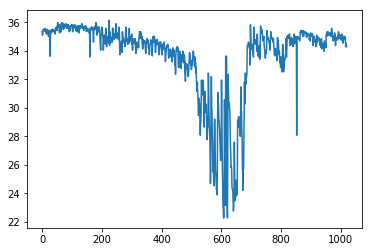

In [68]:
## fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('54460_data.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')
plt.plot(dataset)
plt.show()

In [69]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)


In [70]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

684 337


In [71]:
# reshape into X=t and Y=t+1
look_back = 4
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [72]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 4s - loss: 0.1080
Epoch 2/100
 - 2s - loss: 0.0087
Epoch 3/100
 - 2s - loss: 0.0072
Epoch 4/100
 - 2s - loss: 0.0066
Epoch 5/100
 - 2s - loss: 0.0060
Epoch 6/100
 - 2s - loss: 0.0057
Epoch 7/100
 - 2s - loss: 0.0054
Epoch 8/100
 - 1s - loss: 0.0052
Epoch 9/100
 - 2s - loss: 0.0051
Epoch 10/100
 - 2s - loss: 0.0051
Epoch 11/100
 - 2s - loss: 0.0051
Epoch 12/100
 - 2s - loss: 0.0050
Epoch 13/100
 - 2s - loss: 0.0050
Epoch 14/100
 - 2s - loss: 0.0050
Epoch 15/100
 - 2s - loss: 0.0049
Epoch 16/100
 - 2s - loss: 0.0050
Epoch 17/100
 - 2s - loss: 0.0049
Epoch 18/100
 - 2s - loss: 0.0049
Epoch 19/100
 - 2s - loss: 0.0049
Epoch 20/100
 - 2s - loss: 0.0049
Epoch 21/100
 - 2s - loss: 0.0049
Epoch 22/100
 - 2s - loss: 0.0049
Epoch 23/100
 - 2s - loss: 0.0049
Epoch 24/100
 - 2s - loss: 0.0050
Epoch 25/100
 - 2s - loss: 0.0050
Epoch 26/100
 - 2s - loss: 0.0050
Epoch 27/100
 - 2s - loss: 0.0049
Epoch 28/100
 - 2s - loss: 0.0049
Epoch 29/100
 - 2s - loss: 0.0048
Epoch 30/100
 - 2s - lo

In [73]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))



Train Score: 0.93 RMSE
Test Score: 0.64 RMSE


In [74]:
from sklearn.metrics import mean_absolute_error as mae
accuracy = mae(testY[0], testPredict[:,0])
print(accuracy)


0.3101953827472925


In [75]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [76]:
mean_absolute_percentage_error(testY[0], testPredict[:,0])

0.9098048754092409

In [77]:
from sklearn.metrics import r2_score

print(r2_score(testY[0],testPredict[:,0]))

0.12754787605312223


In [78]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

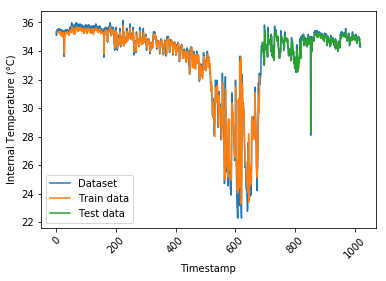

In [79]:
# plot baseline and predictions

df = read_csv('beehive_9803.csv', engine='python', skipfooter=3, parse_dates = ['Timestamp'],
                             index_col = ['Timestamp'])

fig, ax= plt.subplots()

# add the x-axis and the y-axis to the plot
plt.plot( 
        scaler.inverse_transform(dataset), label='Dataset')
plt.plot(trainPredictPlot, label='Train data')
plt.plot( testPredictPlot  , label='Test data')
# rotate tick labels
plt.setp(ax.get_xticklabels(), rotation=45)
ax.set(xlabel="Timestamp",
       ylabel="Internal Temperature (°C)",
       title="");
plt.legend()
#plt.gcf().autofmt_xdate()
plt.show()

# set title and labels for axes
